# CNN using coronary heart disease data

This work is aiming at the design and testing of a deep neural network architecture on Coronary heart disease using Tensorflow and Keras.

## Importing libraries

In [1]:
import numpy as np
import copy
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading the data

In [3]:
# read input file
file = '/content/drive/MyDrive/Senior year/DS 340W/Parent paper 2/CardiacPrediction.xlsx'
#ipData = pd.read_excel(file, sheet_name='Stroke')
ipData = pd.read_excel(file, sheet_name='CoroHeartDis')
print(ipData.columns)

Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')


## Drop variables

In [4]:
# data drop
opLabel = np.array(ipData['CoronaryHeartDisease'])
ipData.drop(['SEQN','CoronaryHeartDisease','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)


#opLabel = np.array(ipData['Stroke'])
#ipData.drop(['SEQN','Stroke','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
 #         'Health-Insurance','Lymphocyte','Monocyte','Eosinophils','Total-Cholesterol','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)



In [5]:
# dummy variable for categorical variables
ipData = pd.get_dummies(ipData,columns=["Gender","Diabetes","Blood-Rel-Diabetes","Blood-Rel-Stroke","Vigorous-work","Moderate-work"])

varb = np.array(ipData.columns)
ipData = np.array(ipData)

In [6]:
print(ipData.shape)
print(varb)
print(len(opLabel[opLabel==0]))
print(len(opLabel[opLabel==1]))

(37079, 45)
['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']
35571
1508


## Feature Nomination using LASSO

In [7]:
#Data condensation using LASSO penalty
from sklearn.linear_model import Lasso, LogisticRegression


featureVote = np.zeros(ipData.shape[1])
print(featureVote.shape)

iteR = 100

for num in range(iteR):
    label0_indx = np.where(opLabel==0)[0]   #no coronary heart disease
    label1_indx = np.where(opLabel==1)[0]   #coronary heart disease
    numTrainData0 = 1300
    numTrainData1 = 1300
    np.random.shuffle(label0_indx)
    np.random.shuffle(label1_indx)

    label0_indx_train = label0_indx[0:numTrainData0-1]
    label1_indx_train = label1_indx[0:numTrainData1-1]
    label0_indx_test  = label0_indx[numTrainData0-1:]
    label1_indx_test  = label1_indx[numTrainData1-1:]

    testIndx  = np.append(label0_indx_test,label1_indx_test)
    trainIndx = np.append(label0_indx_train,label1_indx_train)
    trainData  =  ipData[trainIndx]
    trainLabel =  opLabel[trainIndx]
    testData   =  ipData[testIndx]
    testLabel  =  opLabel[testIndx]

    ##%% data standardization
    scaler = preprocessing.StandardScaler().fit(trainData)
    trainData_scaled = scaler.transform(trainData)
    testData_scaled  = scaler.transform(testData)

    ##%% Elastic net and Lasso from scikit
    #regr = ElasticNet(random_state=0, alpha=1, l1_ratio=0.03, tol=0.000001, max_iter=100000)
    regr = Lasso(random_state=0, alpha=0.006, tol=0.000001, max_iter=100000)
    #regr = LogisticRegression(penalty='l1',random_state=0,C=100,tol=0.000001,max_iter=100,class_weight='balanced')
    regr.fit(trainData_scaled,trainLabel)
    cof = np.abs(regr.coef_)
    colIndx = np.where(cof != 0)[0]
    for col in colIndx:
        featureVote[col]+=1


(45,)


In [8]:
print(featureVote)
print(iter)

[100.  33.  82.  39.  14.  91.  50.  67.   9.  19. 100.  49. 100.  47.
  26.  24.   9. 100.  88.  14.  36.  33. 100.  24.  47.  25. 100.  99.
  96.  95. 100.  59.  86.  73.   5.  87.  49. 100.  60.  14.  13.  89.
   2.  99.  64.]
<built-in function iter>


In [9]:
# feature nomination via Lasso (from feature 1 to 30)
# We keep the dummy variables

#thresH = iteR//5. Pick features occuring more than 5 times
thresH = 0
featureIndx = np.where(featureVote[0:30]>=thresH)[0]
featureIndx = np.append(featureIndx, np.arange(30,ipData.shape[1]))
print(varb[featureIndx])

['Age' 'Systolic' 'Diastolic' 'Weight' 'Body-Mass-Index'
 'White-Blood-Cells' 'Basophils' 'Red-Blood-Cells' 'Hemoglobin'
 'Mean-cell-Hemoglobin' 'Platelet-count' 'Mean-Platelet-Vol'
 'Red-Cell-Distribution-Width' 'Albumin' 'ALP' 'AST' 'ALT' 'Cholesterol'
 'Creatinine' 'Glucose' 'GGT' 'Iron' 'LDH' 'Phosphorus' 'Bilirubin'
 'Protein' 'Uric.Acid' 'Triglycerides' 'HDL' 'Glycohemoglobin' 'Gender_1'
 'Gender_2' 'Diabetes_1' 'Diabetes_2' 'Diabetes_3' 'Blood-Rel-Diabetes_1'
 'Blood-Rel-Diabetes_2' 'Blood-Rel-Stroke_1' 'Blood-Rel-Stroke_2'
 'Vigorous-work_1' 'Vigorous-work_2' 'Vigorous-work_3' 'Moderate-work_1'
 'Moderate-work_2' 'Moderate-work_3']


In [10]:
featureIndx.shape

(45,)

In [11]:
tInx = np.arange(ipData.shape[1])
rrInx = tInx[~np.isin(tInx,featureIndx)]
print(varb[rrInx])

[]


# Dataset reduction (Re-run every time you change the number of training data)

In [12]:

reduced_data = ipData[:,featureIndx]

label0_indx = np.where(opLabel==0)[0]   #no cardiac arrest
label1_indx = np.where(opLabel==1)[0]   #cardiac arrest
numTrainData0 = 4300
numTrainData1 = 1169
np.random.shuffle(label0_indx)
np.random.shuffle(label1_indx)

label0_indx_train = label0_indx[0:numTrainData0]
label1_indx_train = label1_indx[0:numTrainData1]
label0_indx_test  = label0_indx[numTrainData0:]
label1_indx_test  = label1_indx[numTrainData1:]

testIndx  = np.append(label0_indx_test,label1_indx_test)
trainIndx = np.append(label0_indx_train,label1_indx_train)
x_train  =  reduced_data[trainIndx]
y_train  =  opLabel[trainIndx]
x_test   =  reduced_data[testIndx]
y_test   =  opLabel[testIndx]

In [13]:
print(len(label0_indx_test))

31271


In [14]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

x_train_org = copy.deepcopy(x_train)
x_test_org  = copy.deepcopy(x_test)
y_train_org     = copy.deepcopy(y_train)
y_test_org      = copy.deepcopy(y_test)

## t-SNE visualization

In [15]:
# t-SNE visualization
import imblearn
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns

In [16]:
X_embedded = TSNE(n_components=3, n_iter = 300, verbose=1).fit_transform(x_train)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5469 samples in 0.001s...
[t-SNE] Computed neighbors for 5469 samples in 0.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5469
[t-SNE] Computed conditional probabilities for sample 2000 / 5469
[t-SNE] Computed conditional probabilities for sample 3000 / 5469
[t-SNE] Computed conditional probabilities for sample 4000 / 5469
[t-SNE] Computed conditional probabilities for sample 5000 / 5469
[t-SNE] Computed conditional probabilities for sample 5469 / 5469
[t-SNE] Mean sigma: 1.776332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.125397
[t-SNE] KL divergence after 300 iterations: 2.375069


<ipython-input-17-57e647667309>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(0,0,0,c=cin,edgecolors='k',label='CHD')


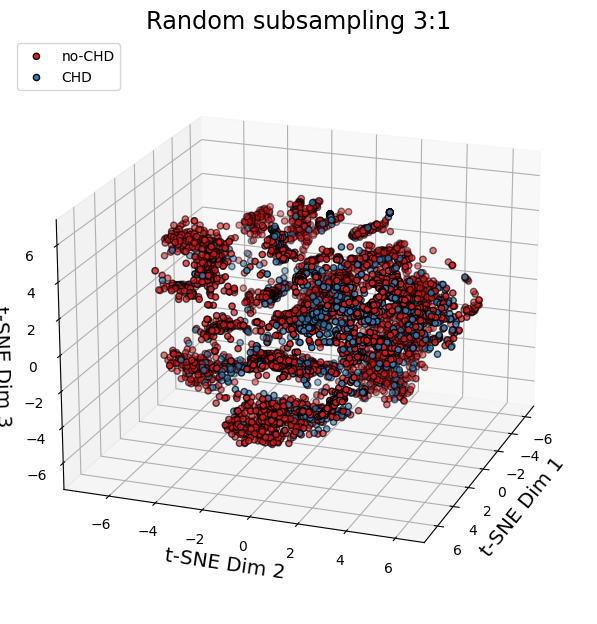

In [17]:
from mpl_toolkits.mplot3d import Axes3D

cin = sns.color_palette("Set1")[1]
edge_color = []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('w')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2],c=[sns.color_palette("Set1")[x] for x in y_train],\
           edgecolors='k',label='no-CHD')
ax.scatter(0,0,0,c=cin,edgecolors='k',label='CHD')
ax.azim = 20
ax.elev = 20
ax.set_xlabel("t-SNE Dim 1", size="x-large")
ax.set_ylabel("t-SNE Dim 2", size="x-large")
ax.set_zlabel("t-SNE Dim 3", size="x-large")
plt.title("Random subsampling 3:1",size="xx-large")
ax.legend(loc='upper left')
fig.set_size_inches(7.5,7.5)
fig.savefig('tSNE_RUS.png', dpi=100)

In [18]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [19]:
#%% one-hot-encoding
y_train = keras.utils.to_categorical(y_train,2)
y_test  = keras.utils.to_categorical(y_test,2)

In [20]:
#y_train.shape
#y_train
y_train_org

array([0, 0, 0, ..., 1, 1, 1])

# Running the part above is MANDATORY for training any Network below

## MLP only

In [21]:
# MLP -2
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)


FC2 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(DP1)
outputs = keras.layers.Activation('softmax')(FC2)

myMLP = keras.Model(inputs=inputs,outputs=outputs)
myMLP.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape (Reshape)           (None, 45)                0         
                                                                 
 dense (Dense)               (None, 512)               23552     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [22]:
class_weight = {0: 1, 1: 10}

myMLP.fit(x_train,y_train,epochs=50,batch_size=500,verbose=1, class_weight=class_weight)

Epoch 1/50
11/11 [==============================] - 2s 37ms/step - loss: 1.6266 - accuracy: 0.6219
Epoch 2/50
11/11 [==============================] - 0s 32ms/step - loss: 1.3057 - accuracy: 0.6442
Epoch 3/50
11/11 [==============================] - 0s 33ms/step - loss: 1.1256 - accuracy: 0.6679
Epoch 4/50
11/11 [==============================] - 0s 34ms/step - loss: 1.0781 - accuracy: 0.6992
Epoch 5/50
11/11 [==============================] - 0s 32ms/step - loss: 1.0294 - accuracy: 0.7146
Epoch 6/50
11/11 [==============================] - 0s 30ms/step - loss: 1.0027 - accuracy: 0.7206
Epoch 7/50
11/11 [==============================] - 0s 36ms/step - loss: 0.9991 - accuracy: 0.7210
Epoch 8/50
11/11 [==============================] - 0s 34ms/step - loss: 0.9346 - accuracy: 0.7277
Epoch 9/50
11/11 [==============================] - 0s 30ms/step - loss: 0.9462 - accuracy: 0.7321
Epoch 10/50
11/11 [==============================] - 0s 33ms/step - loss: 0.8994 - accuracy: 0.7398
Epoch 11/

In [23]:
test_loss,test_acc = myMLP.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 2s 2ms/step - loss: 0.4570 - accuracy: 0.8097
0.8097121119499207


In [24]:
from sklearn import metrics
predlabel = myMLP.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 2s 2ms/step
[[25357  5914]
 [  101   238]]


## MLP with additional layers

In [25]:
# MLP -3 :: Input => Hidden(64) => Hidden(128) => Hidden(256)
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)

FC2    = keras.layers.Dense(256, bias_initializer=keras.initializers.VarianceScaling())(DP1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myMLP3 = keras.Model(inputs=inputs,outputs=outputs)
myMLP3.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_1 (Reshape)         (None, 45)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                2944      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                           

In [26]:
class_weight = {0: 1, 1: 2.2}

myMLP3.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 3s 4ms/step - loss: 0.7417 - accuracy: 0.7400


In [27]:
test_loss,test_acc = myMLP3.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 2s 2ms/step - loss: 0.5765 - accuracy: 0.6885
0.6885479092597961


In [28]:
from sklearn import metrics
predlabel = myMLP3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 2s 2ms/step
[[21476  9795]
 [   50   289]]


# Introducing convolutional layers

## MLP+Conv :: Input => Hidden(128)  => Conv(4) => Output (2)

In [29]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D1 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D1.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D1.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_2 (Reshape)         (None, 45)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               5888      
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                           

In [30]:
class_weight = {0: 1, 1: 4}

myCNN1D1.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 2s 5ms/step - loss: 0.9973 - accuracy: 0.6729


In [31]:
test_loss,test_acc = myCNN1D1.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 3s 2ms/step - loss: 0.5683 - accuracy: 0.7332
0.7331540584564209


In [32]:
from sklearn import metrics
predlabel = myCNN1D1.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 2s 2ms/step
[[22901  8370]
 [   65   274]]


##  MLP+CONV: Input => Hidden(128)  => Conv(4) => Conv(8) => Output (2)

In [33]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((128,1))(DP0)
FC1    = keras.layers.Conv1D(4,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(8,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2 = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1   = keras.layers.Flatten()(Pool2)

FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(FL1)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D2 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D2.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_4 (Reshape)         (None, 45)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               5888      
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 128)               0         
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                           

In [34]:
class_weight = {0: 1, 1: 4.5}

myCNN1D2.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 4s 7ms/step - loss: 1.0600 - accuracy: 0.6449


In [35]:
test_loss,test_acc = myCNN1D2.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 4s 4ms/step - loss: 0.5291 - accuracy: 0.7705
0.7704523801803589


In [36]:
from sklearn import metrics
predlabel = myCNN1D2.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 3s 3ms/step
[[24103  7168]
 [   88   251]]


## MLP+Conv :: Input => Hidden(64) => Conv(2) => Hidden(512)  

In [37]:

inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(32, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((32,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1 = keras.layers.MaxPool1D(pool_size=2)(AC1)
FL1   = keras.layers.Flatten()(Pool1)

FC2    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
#DP2    = keras.layers.Dropout(0.2)(AC2)


FC3 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(AC2)
outputs = keras.layers.Activation('softmax')(FC3)

myCNN1D3 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D3.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myCNN1D3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_6 (Reshape)         (None, 45)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                1472      
                                                                 
 batch_normalization_10 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 32)                0         
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                           

In [38]:
class_weight = {0: 1, 1: 50}

myCNN1D3.fit(x_train,y_train,epochs=5,verbose=1, class_weight=class_weight)

Epoch 1/5
171/171 [==============================] - 4s 6ms/step - loss: 3.4130 - accuracy: 0.2368
Epoch 2/5
171/171 [==============================] - 1s 5ms/step - loss: 2.6503 - accuracy: 0.2514
Epoch 3/5
171/171 [==============================] - 1s 6ms/step - loss: 2.4793 - accuracy: 0.3172
Epoch 4/5
171/171 [==============================] - 1s 4ms/step - loss: 2.3401 - accuracy: 0.3456
Epoch 5/5
171/171 [==============================] - 1s 4ms/step - loss: 2.2894 - accuracy: 0.3575


In [39]:
test_loss,test_acc = myCNN1D3.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 2s 2ms/step - loss: 1.7761 - accuracy: 0.2358
0.23577982187271118


In [40]:
from sklearn import metrics
predlabel = myCNN1D3.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 2s 2ms/step
[[ 7116 24155]
 [    2   337]]


## MLP+ CONV: Input => Dense(64) => Conv(2) => Conv(4) = Dense(512) => Dense (2) [Best model]

In [43]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)

FL1    = keras.layers.Flatten()(Pool2)

FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(DP3)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN1D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN1D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN1D4.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_10 (Reshape)        (None, 45)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                2944      
                                                                 
 batch_normalization_17 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_23 (Activation)  (None, 64)                0         
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                           

In [44]:
class_weight = {0: 1, 1: 2.9}

myCNN1D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 4s 7ms/step - loss: 0.9207 - accuracy: 0.7016


In [45]:
test_loss,test_acc = myCNN1D4.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 4s 4ms/step - loss: 0.4725 - accuracy: 0.8829
0.8829168081283569


In [46]:
from sklearn import metrics
predlabel = myCNN1D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 3s 3ms/step
[[27751  3520]
 [  181   158]]


In [49]:
y_train @ np.transpose(np.array([0, 1]))
1/41

0.024390243902439025

## Input => Dense(64) => Conv(2) => Conv(4) = Conv(8) => Dense (2)

In [48]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FC2    = keras.layers.Conv1D(4,5,strides=1)(Pool1)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool2  = keras.layers.AveragePooling1D(pool_size=2)(AC2)


FC3    = keras.layers.Conv1D(6,7,strides=1)(Pool2)
BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
AC3    = keras.layers.Activation('relu')(BN3)
Pool3  = keras.layers.AveragePooling1D(pool_size=2)(AC3)




FL1    = keras.layers.Flatten()(Pool3)

#FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
#BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
#AC3    = keras.layers.Activation('relu')(BN3)
#DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(FL1)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN5D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN5D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN5D4.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_12 (Reshape)        (None, 45)                0         
                                                                 
 dense_20 (Dense)            (None, 64)                2944      
                                                                 
 batch_normalization_21 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 64)                0         
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                           

In [50]:
class_weight = {0: 1, 1: 3.0}

myCNN5D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 4s 8ms/step - loss: 0.8755 - accuracy: 0.7305


In [51]:
test_loss,test_acc = myCNN5D4.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 3s 3ms/step - loss: 0.5247 - accuracy: 0.8185
0.8185384273529053


In [52]:
from sklearn import metrics
predlabel = myCNN5D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 3s 3ms/step
[[25662  5609]
 [  127   212]]


## Input => Dense(64) => Conv(2) => Dense (128) = Conv(4) => Dense (2)

In [53]:
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(64, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

RS1    = keras.layers.Reshape((64,1))(DP0)
FC1    = keras.layers.Conv1D(2,3,strides=1)(RS1)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
Pool1  = keras.layers.AveragePooling1D(pool_size=2)(AC1)

FL0 = keras.layers.Flatten()(Pool1)

AA1 = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(FL0)
BB1 = keras.layers.BatchNormalization(axis=-1)(AA1)
CC1 = keras.layers.Activation('relu')(BB1)
Pool2 = keras.layers.Dropout(0.2)(CC1)


RS2    = keras.layers.Reshape((128,1))(Pool2)
FC2    = keras.layers.Conv1D(4,5,strides=1)(RS2)
BN2    = keras.layers.BatchNormalization(axis=-1)(FC2)
AC2    = keras.layers.Activation('relu')(BN2)
Pool3  = keras.layers.AveragePooling1D(pool_size=2)(AC2)



FL1    = keras.layers.Flatten()(Pool3)

#FC3    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(FL1)
#BN3    = keras.layers.BatchNormalization(axis=-1)(FC3)
#AC3    = keras.layers.Activation('relu')(BN3)
#DP3    = keras.layers.Dropout(0.2)(AC3)


FC4    = keras.layers.Dense(2)(FL1)
outputs = keras.layers.Activation('softmax')(FC4)

myCNN5D4 = keras.Model(inputs=inputs,outputs=outputs)
myCNN5D4.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

myCNN5D4.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 reshape_14 (Reshape)        (None, 45)                0         
                                                                 
 dense_22 (Dense)            (None, 64)                2944      
                                                                 
 batch_normalization_25 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 64)                0         
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                           

In [54]:
class_weight = {0: 1, 1: 2.5}

myCNN5D4.fit(x_train,y_train,epochs=1,verbose=1, class_weight=class_weight)

171/171 [==============================] - 4s 7ms/step - loss: 0.7660 - accuracy: 0.7436


In [55]:
test_loss,test_acc = myCNN5D4.evaluate(x_test,y_test)
print(test_acc)

988/988 [==============================] - 5s 5ms/step - loss: 0.3865 - accuracy: 0.9472
0.9472002387046814


In [56]:
from sklearn import metrics
predlabel = myCNN5D4.predict(x_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(y_test,axis=1),f)
print(confMat)

988/988 [==============================] - 3s 3ms/step
[[29841  1430]
 [  239   100]]


# Running SVM on the subsampled data

In [68]:
from sklearn.svm import SVC
from sklearn import metrics

svcCAD = SVC(C= 0.05, gamma=1/41, kernel='rbf', class_weight='balanced')
svcCAD.fit(x_train_org,y_train_org)
predlabel = svcCAD.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)
print(confMat)

[[22274  8997]
 [   57   282]]


# Running random forest and adaboost

In [63]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
class_weight = {0: 1, 1: 3}
adaboostCAD = AdaBoostClassifier(n_estimators=1000, random_state=0)
adaboostCAD.fit(x_train_org,y_train_org)
predlabel = adaboostCAD.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)
print(confMat)

[[28348  2923]
 [  179   160]]


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#randomforestCAD = RandomForestClassifier(max_depth=3, random_state=0, class_weight='balanced_subsample')

parameters = {'n_estimators': (10,30,50,100,130,160,200), 'max_depth': (2, 3)}
randomforestCAD = GridSearchCV(RandomForestClassifier(random_state=0, class_weight='balanced_subsample'),
                               parameters, cv=5)



randomforestCAD.fit(x_train_org,y_train_org)
#predlabel = randomforestCAD.predict(x_test_org)
#confMat = metrics.confusion_matrix(y_test_org,predlabel)
#print(confMat)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=0),
             param_grid={'max_depth': (2, 3),
                         'n_estimators': (10, 30, 50, 100, 130, 160, 200)})

In [65]:
print(randomforestCAD.cv_results_)
print(randomforestCAD.best_estimator_)

{'mean_fit_time': array([0.05220814, 0.15446668, 0.24695148, 0.73069839, 0.68132243,
       0.77916837, 1.14205489, 0.09145408, 0.25260282, 0.287602  ,
       0.55741043, 0.71545048, 1.17927127, 1.10703812]), 'std_fit_time': array([0.00348983, 0.00959232, 0.00676161, 0.04743228, 0.10968164,
       0.01713793, 0.22512366, 0.00248883, 0.01720394, 0.01708035,
       0.01297322, 0.00563671, 0.24904334, 0.03553399]), 'mean_score_time': array([0.00261774, 0.00511575, 0.00787921, 0.02045698, 0.01735725,
       0.02077441, 0.02897115, 0.00393271, 0.00675697, 0.00850568,
       0.01434054, 0.02063742, 0.02838082, 0.02809944]), 'std_score_time': array([0.00012868, 0.00025205, 0.00081223, 0.002174  , 0.00059723,
       0.00040653, 0.00441806, 0.00028482, 0.00074924, 0.00098622,
       0.00030407, 0.00325995, 0.00512023, 0.00135751]), 'param_max_depth': masked_array(data=[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3],
             mask=[False, False, False, False, False, False, False, False,
         

In [66]:
randomforestCADopt = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

randomforestCADopt.fit(x_train_org,y_train_org)
predlabel = randomforestCADopt.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)
print(confMat)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[[23638  7633]
 [   84   255]]


# The following section shows the result when 70% of data are used for training

In [69]:
# With train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(reduced_data, opLabel, test_size = 0.3, random_state = 24)

In [70]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [71]:
#%% one-hot-encoding
Y_train = keras.utils.to_categorical(Y_train,2)
Y_test  = keras.utils.to_categorical(Y_test,2)

In [72]:
# MLP -2
inputs = keras.layers.Input(shape=(x_train.shape[1],1))
RS0    = keras.layers.Reshape((x_train.shape[1], ))(inputs)
FC0    = keras.layers.Dense(512, bias_initializer=keras.initializers.VarianceScaling())(RS0)
BN0    = keras.layers.BatchNormalization(axis=-1)(FC0)
AC0    = keras.layers.Activation('relu')(BN0)
DP0    = keras.layers.Dropout(0.2)(AC0)

FC1    = keras.layers.Dense(128, bias_initializer=keras.initializers.VarianceScaling())(DP0)
BN1    = keras.layers.BatchNormalization(axis=-1)(FC1)
AC1    = keras.layers.Activation('relu')(BN1)
DP1    = keras.layers.Dropout(0.2)(AC1)


FC2 =   keras.layers.Dense(2, bias_initializer=keras.initializers.VarianceScaling())(DP1)
outputs = keras.layers.Activation('softmax')(FC2)

myMLP = keras.Model(inputs=inputs,outputs=outputs)
myMLP.compile(optimizer=keras.optimizers.Adam(lr=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
myMLP.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 45, 1)]           0         
                                                                 
 reshape_17 (Reshape)        (None, 45)                0         
                                                                 
 dense_25 (Dense)            (None, 512)               23552     
                                                                 
 batch_normalization_29 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_38 (Activation)  (None, 512)               0         
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                           

In [73]:
np.where(Y_train==0)[0].shape
np.where(Y_train==1)[0].shape


(25955,)

In [74]:
class_weight = {0: 1, 1: 40}

myMLP.fit(X_train,Y_train,epochs=10,batch_size=1200,verbose=1, class_weight=class_weight)

Epoch 1/10
22/22 [==============================] - 2s 41ms/step - loss: 1.4615 - accuracy: 0.5605
Epoch 2/10
22/22 [==============================] - 1s 40ms/step - loss: 1.1673 - accuracy: 0.6967
Epoch 3/10
22/22 [==============================] - 1s 40ms/step - loss: 1.0692 - accuracy: 0.6955
Epoch 4/10
22/22 [==============================] - 1s 39ms/step - loss: 1.0283 - accuracy: 0.7211
Epoch 5/10
22/22 [==============================] - 1s 40ms/step - loss: 0.9904 - accuracy: 0.7212
Epoch 6/10
22/22 [==============================] - 1s 40ms/step - loss: 0.9763 - accuracy: 0.7192
Epoch 7/10
22/22 [==============================] - 1s 40ms/step - loss: 0.9271 - accuracy: 0.7414
Epoch 8/10
22/22 [==============================] - 1s 38ms/step - loss: 0.8892 - accuracy: 0.7435
Epoch 9/10
22/22 [==============================] - 1s 40ms/step - loss: 0.8677 - accuracy: 0.7360
Epoch 10/10
22/22 [==============================] - 1s 43ms/step - loss: 0.8600 - accuracy: 0.7546


In [75]:
test_loss,test_acc = myMLP.evaluate(X_test,Y_test)
print(test_acc)

348/348 [==============================] - 1s 2ms/step - loss: 0.4984 - accuracy: 0.7402
0.7402013540267944


In [76]:
from sklearn import metrics
predlabel = myMLP.predict(X_test)
f = np.argmax(predlabel,axis=1)
confMat = metrics.confusion_matrix(np.argmax(Y_test,axis=1),f)
print(confMat)

348/348 [==============================] - 1s 2ms/step
[[7839 2820]
 [  70  395]]


## Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = 'lbfgs',max_iter=100000,
                           class_weight= {0:1, 1:3.0}, verbose=1, random_state = 2)
model = clf.fit(x_train_org,y_train_org)

In [78]:
predlabel = model.predict(x_test_org)
confMat = metrics.confusion_matrix(y_test_org,predlabel)

In [79]:
print(confMat)

[[24944  6327]
 [   77   262]]
